# Finite difference vs. Fourier differentiation

This illustrates the difference between finite difference approximation and Fourier spectral approximation for a smooth periodic function.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Suppose we are given a function $v(x)$ that is $2\pi$-periodic, i.e. we know the values for $0 \leq x \leq 2\pi$, and we wish to approximate the derivative $v\prime(x)$ at points in this interval.  

To be specific, choose $N$ equally spaced points $x_j = jh$ with equal spacing $h = 2\pi / N$, for $j=1,~2,~\ldots,~N$.  Then we know the discrete function values $v_j = v(x_j)$ and want to compute approximations $w_j\approx v\prime(x_j)$ or $z_j \approx v\prime\prime(x_j)$.

## Finite differences

One approach is to use a finite difference approximation, e.g. 
$$
v\prime(x_j) = \frac{v_{j+1}-v_{j-1}}{2h} + O(h^2)
$$
This can be derived by Taylor series expansion, or by finding a quadratic interpolating polynomial through the three points $v_{j-1},~ v_j,~ v_{j+1}$, differentiating this polynomial and evaluating at $x_j$.

The matrix formulation is (1.2) in SMM, which we can write as $w = D_1 v$ with 

$$
D_1 = \frac{1}{2h}
\left(\begin{array}[rrrrrr]
 0&1&&&&-1\\
-1&0&1\\
&-1&0&1\\
&&&\ddots\\
&&&-1&0&1\\
1&&&&-1&0
\end{array}\right)
$$

Similarly the centered difference approximation to $v\prime\prime(x) = \frac 1 {h^2} (v(x-h) - 2v(x) + v(x+h)) + O(h^2)$ can be written as $z = D_2 v$ (so that $z_j \approx v\prime\prime(x_j)$) with
$$
D_2 = \frac{1}{h^2}
\left(\begin{array}[rrrrrr]
-2&1&&&&1\\
1&-2&1\\
&1&-2&1\\
&&&\ddots\\
&&&1&-2&1\\
1&&&&1&-2
\end{array}\right)
$$

Note that another way to approximate the second derivative would be to apply $D_1$ to $D_1v$.  But note that $D_1^2 \neq D_2$, instead this would correspond to using a centered approximation 
$$
v\prime\prime(x_j) \approx \frac{1}{(2h)^2} (v_{j-2} - 2v_j + v_{j+2})
$$ 
which is still second-order accurate but with the larger mesh spacing $2h$.

## Python code 

Choose a function $v(x)$ and work out the derivatives:

In [2]:
v_0 = lambda x: exp(sin(x))
v_1 = lambda x: cos(x) * exp(sin(x))
v_2 = lambda x: (cos(x)**2 - sin(x)) * exp(sin(x))

# fine grid for plotting function and true derivative:
x_fine = linspace(0,2*pi,1000)  
v_fine = v_0(x_fine)
z_fine = v_2(x_fine)

We can use the `spdiags` function from `scipy.sparse` to set up a sparse matrix. 


In [3]:
from scipy.sparse import spdiags

N = 10
h = 2*pi / N
e = ones((N,1))
data = hstack([e, e, -2*e, e, e]).T
diags = [-N+1, -1, 0, 1, N-1]
T = spdiags(data, diags, N, N)
D2 = (1./h**2) * T

For small `N` we can print the `D2` matrix without the $1/h^2$ factor so we can verify we did it right:

In [4]:
print h**2 * D2.todense()

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


max error in second derivative is 0.217425


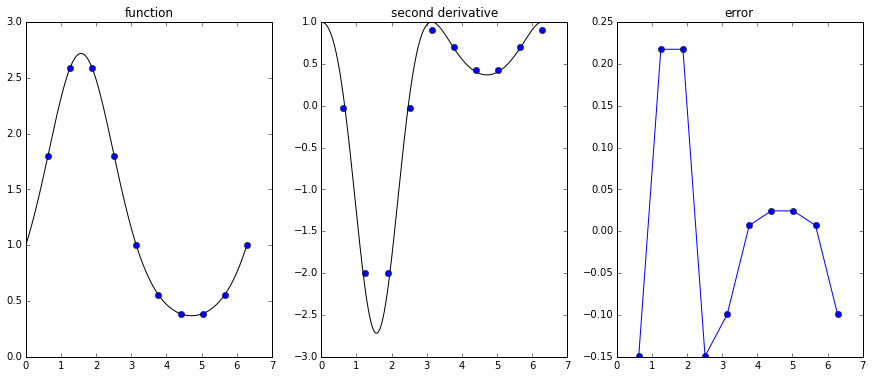

In [5]:
x = linspace(h,2*pi,N)  # computational grid
v = v_0(x)      # evaluate v(x_j)
z = D2.dot(v)   # sparse matrix vector product D2 * v

# The rest is just plotting...

figure(figsize=(15,6))
subplot(1,3,1)
plot(x_fine, v_fine, 'k')
plot(x,v,'bo')
title('function')

subplot(1,3,2)
plot(x_fine, z_fine, 'k')
plot(x,z,'bo')
title('second derivative')

subplot(1,3,3)
error = z - v_2(x)
plot(x, error, 'bo-')
title('error')

print "max error in second derivative is %g" % norm(error,inf)

## Spectral approximation

Contrast the results above with what we can achieve with a spectral approximation.  For this periodic function we can use Fourier transforms, similar to the approach in SMM `p5.m` but now for the second derivative.  Note that the DFT is used rather than the matrix form of the differentiation matrix.

max error in second derivative is 0.000887649


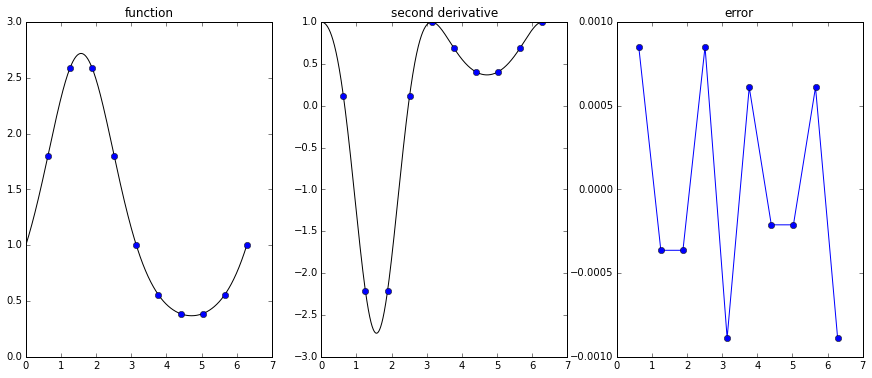

In [6]:
from scipy import fft,ifft
N = 10;
x = linspace(2*pi/N,2*pi,N)

ik = 1j*hstack((range(0,N/2+1), range(-N/2+1,0)));   # i * wave number vector (matlab ordering)
ik2 = ik*ik;          # multiplication factor for second derivative

v = v_0(x)
v_hat = fft(v)
z_hat = ik2 * v_hat
z = real(ifft(z_hat))     # imaginary part should be at machine precision level

# That's it, the rest is just plotting...

figure(figsize=(15,6))
subplot(1,3,1)
plot(x_fine, v_fine, 'k')
plot(x,v,'bo')
title('function')

subplot(1,3,2)
plot(x_fine, z_fine, 'k')
plot(x,z,'bo')
title('second derivative')

subplot(1,3,3)
error = z - v_2(x)
plot(x, error, 'bo-')
title('error')

print "max error in second derivative is %g" % norm(error,inf)

### Fourth derivative

Note that we can easily use the FFT form to approximate the 4th derivative of v(x).

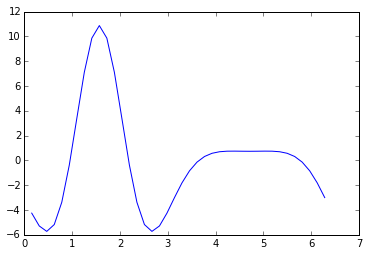

In [7]:
N = 40;
x = linspace(2*pi/N,2*pi,N)

ik = 1j*hstack((range(0,N/2+1), range(-N/2+1,0)));   # i * wave number vector (matlab ordering)
ik4 = ik**4;          # multiplication factor for fourth derivative

v = v_0(x)
v_hat = fft(v)
z_hat = ik4 * v_hat
z = real(ifft(z_hat))     # imaginary part should be at machine precision level

plot(x,z)

Why is this shape familiar from above?